### Problem 1 - Gradient Descent and Convergence Rate

1. The gradient descent updates with leaning rate epsilon :  $w^{(t+1)} = w^{(t)} - \epsilon \Phi (\Phi^T w^{(t)} - y)$.
2. Lamda max represents the largest eigenvalue of Hessian matrix and the convergence of gradient descent is guaranteed when epsilon (assume learning rate) is less than 2/lamda max. The Hessian for the loss is $H=\Phi \Phi^T $



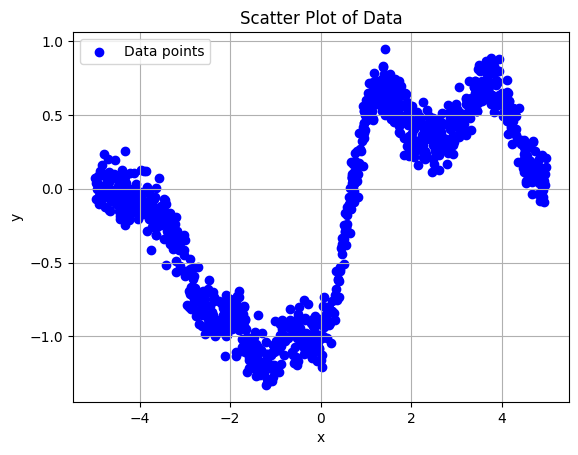

In [40]:
#Always visualize data
import numpy as np
import matplotlib.pyplot as plt

# Load data
data = np.load("hw1_p1.npy")
x, y = data[:, 0], data[:, 1]

# Visualize the data
plt.scatter(x, y, color='blue', label="Data points")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Scatter Plot of Data")
plt.grid(True)
plt.legend()
plt.show()


In [41]:
# Define Gaussian basis functions
def gaussian_basis(x, centers, sigma=0.25):
    
    return np.exp(-((x[:, None] - centers[None, :]) ** 2) / (2 * sigma ** 2))

# Define centers and create the feature matrix
M = 7
centers = np.array([1.25 * m - 3.75 for m in range(M)])
sigma = 0.25

Phi = gaussian_basis(x, centers, sigma)

# Verify Phi dimensions
print(f"Feature matrix Phi shape:", Phi.shape)


Feature matrix Phi shape: (1000, 7)


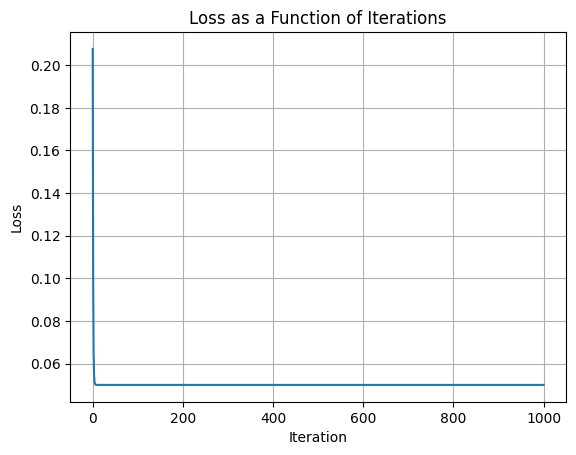

In [42]:
# Mean Squared Error loss
def mse_loss(Phi, w, y):

    residuals = Phi @ w - y
    return 0.5 * np.mean(residuals ** 2)

# Gradient descent implementation
def gradient_descent(Phi, y, w_init, epsilon, num_steps):
    
    w = w_init
    w_history = [w.copy()]
    loss_history = [mse_loss(Phi, w, y)]

    for step in range(num_steps):
        
        gradient = Phi.T @ (Phi @ w - y)

        w = w - epsilon * gradient

        w_history.append(w.copy())
        loss_history.append(mse_loss(Phi, w, y))

    return w_history, loss_history

# Initialize weights
w_init = np.zeros(Phi.shape[1])
epsilon = 0.01
num_steps = 1000

# Run gradient descent
w_history, loss_history = gradient_descent(Phi, y, w_init, epsilon, num_steps)

# Plot the loss over iterations
plt.plot(loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss as a Function of Iterations")
plt.grid(True)
plt.show()


### Reflection on the chart
* In above chart, we can observe that the lost function starts relatively high in the first itaretion but quickly decreases within the first steps, showing rapid progress towards the optimal solution.

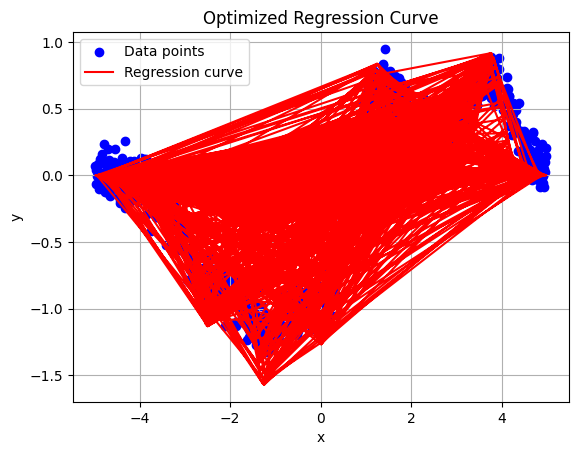

In [43]:
# Optimized weights
w_opt = w_history[-1]

# Compute predictions
y_pred = Phi @ w_opt

# Plot the data and regression curve
plt.scatter(x, y, color='blue', label="Data points")
plt.plot(x, y_pred, color='red', label="Regression curve")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Optimized Regression Curve")
plt.grid(True)
plt.show()


### Reflection on the chart
* Red lines, which dipict the predicted regression curves using Gaussian, fail to follow smoothly the data points, blue points. Potential issues with that are function selection, learning rate or over/underfitting. From the tangled nature of those red lines, one can say that there is poor convergence or I can say that there is inadequate learning rate such that learning rate is likely high or low relative to the theoritical upper bounding.

In [44]:
# Compute Hessian matrix
H = Phi.T @ Phi  # Hessian is Phi^T Phi

# Eigenvalues of the Hessian
eigenvalues = np.linalg.eigvals(H)
lambda_max = np.max(eigenvalues)  # Maximum eigenvalue
epsilon_upper_bound = 2 / lambda_max

print("Maximum eigenvalue of the Hessian:", lambda_max)
print("Theoretical upper bound for learning rate:", epsilon_upper_bound)


Maximum eigenvalue of the Hessian: 51.920171616338365
Theoretical upper bound for learning rate: 0.0385206739064521


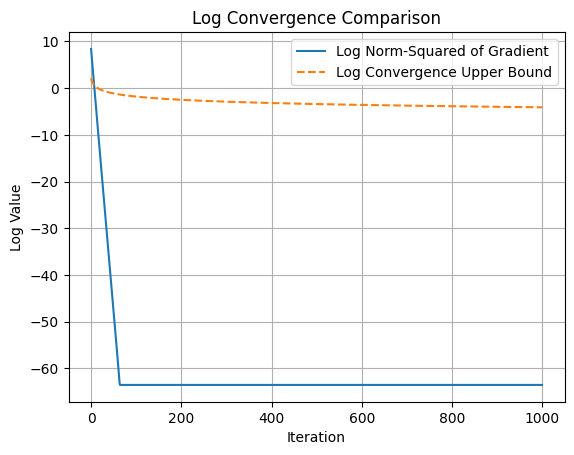

In [45]:
# Compute gradient norms
gradient_norms = [np.linalg.norm(Phi.T @ (Phi @ w - y)) ** 2 for w in w_history]

# Theoretical convergence bound
convergence_bound = [
    2 * lambda_max * (loss_history[0] - loss_history[-1]) / (t + 1)
    for t in range(1, len(loss_history))
]

# Logarithmic convergence plot
plt.plot(np.log(gradient_norms[1:]), label="Log Norm-Squared of Gradient")
plt.plot(np.log(convergence_bound), label="Log Convergence Upper Bound", linestyle="--")
plt.xlabel("Iteration")
plt.ylabel("Log Value")
plt.legend()
plt.title("Log Convergence Comparison")
plt.grid(True)
plt.show()


### Reflection on the chart

The blue line consistantly stays below the orange dashed line. It means that leaning rate, epsilon, adheres to the theoretical constraints. It ensures stability and convergence. The norm squared gradient approaches a very small value near iteration 200. After that it stablizes. 

### Problem 2

1. Here is my smallest MLP architecture: Input Layer (featuresOfX) + Hidden Layer (minimum#OfNeurons) + Output Layer (oneNeuronWithSigmoidActivation). Sigmoid Activation is used in both Hidden and Output Layers. Weights and baises are randomly initialized.

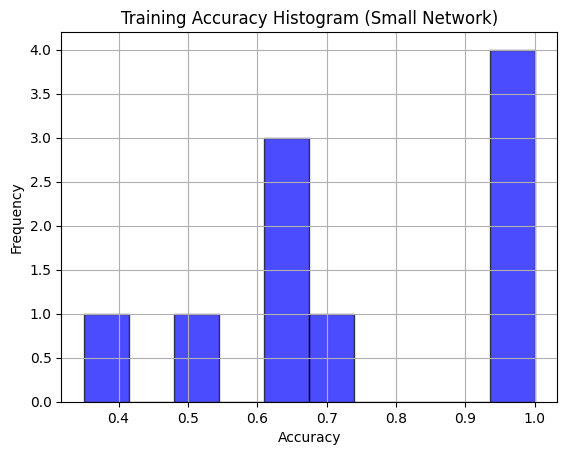

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the dataset
data = np.load('hw1_p2.npy')
X, y = data[:, :2], data[:, 2]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the MLP class
class SimpleMLP:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.W1 = np.random.randn(input_dim, hidden_dim)
        self.b1 = np.zeros(hidden_dim)                    
        self.W2 = np.random.randn(hidden_dim, output_dim) 
        self.b2 = np.zeros(output_dim)                    

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, z):
        return self.sigmoid(z) * (1 - self.sigmoid(z))

    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.sigmoid(self.z2)
        return self.a2

    def backward(self, X, y, y_pred, learning_rate):
        m = X.shape[0]
        dz2 = y_pred - y.reshape(-1, 1)
        dW2 = np.dot(self.a1.T, dz2) / m
        db2 = np.sum(dz2, axis=0) / m

        dz1 = np.dot(dz2, self.W2.T) * self.sigmoid_derivative(self.z1)
        dW1 = np.dot(X.T, dz1) / m
        db1 = np.sum(dz1, axis=0) / m

        # Update weights and biases
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2

    def train(self, X, y, epochs=1000, learning_rate=0.1):
        for epoch in range(epochs):
            y_pred = self.forward(X)
            self.backward(X, y, y_pred, learning_rate)

    def predict(self, X):
        y_pred = self.forward(X)
        return (y_pred > 0.5).astype(int)

# Train and evaluate the model on 10 runs
accuracies = []
for run in range(10):
    np.random.seed(run)
    mlp = SimpleMLP(input_dim=2, hidden_dim=2, output_dim=1)
    mlp.train(X_train, y_train, epochs=1000, learning_rate=0.1)
    
    y_pred = mlp.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Plot histogram of accuracies
plt.hist(accuracies, bins=10, color='blue', edgecolor='black', alpha=0.7)
plt.title('Training Accuracy Histogram (Small Network)')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


### Reflection on the chart

The histogram of training accuracies suggests that with a small network size, the model fails to find a consistent solution across all runs. This inconsistency might be due to insufficient capacity or poor weight initialization in the minimal network. My analysis is that smaller network size has probabily insufficient capacity to campture complex functions or patterns in the data.

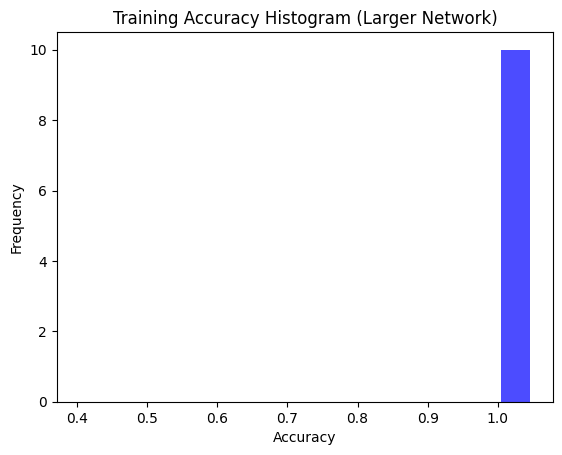

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the dataset
data = np.load('hw1_p2.npy', allow_pickle=True)
X = data[:, :-1]
y = data[:, -1]

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define MLP with a larger hidden layer (10 neurons)
class MLP:
    def __init__(self, input_size, hidden_size, output_size):
        # Randomly initialize weights and biases
        self.W1 = np.random.randn(input_size, hidden_size)
        self.b1 = np.zeros(hidden_size)
        self.W2 = np.random.randn(hidden_size, output_size)
        self.b2 = np.zeros(output_size)
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def sigmoid_derivative(self, z):
        return self.sigmoid(z) * (1 - self.sigmoid(z))
    
    def forward(self, X):
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self.sigmoid(self.Z1)
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self.sigmoid(self.Z2)
        return self.A2
    
    def backward(self, X, y, output, learning_rate):
        m = X.shape[0]
        dZ2 = output - y
        dW2 = np.dot(self.A1.T, dZ2) / m
        db2 = np.sum(dZ2, axis=0) / m
        
        dZ1 = np.dot(dZ2, self.W2.T) * self.sigmoid_derivative(self.Z1)
        dW1 = np.dot(X.T, dZ1) / m
        db1 = np.sum(dZ1, axis=0) / m
        
        # Update weights and biases
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
    
    def train(self, X, y, epochs, learning_rate):
        for epoch in range(epochs):
            output = self.forward(X)
            self.backward(X, y, output, learning_rate)
    
    def predict(self, X):
        output = self.forward(X)
        return np.round(output)

# Experiment: Train larger network (hidden size = 10 neurons) for 10 runs
hidden_size = 10
input_size = X_train.shape[1]
output_size = 1
epochs = 1000
learning_rate = 0.1

accuracies = []
for _ in range(10):
    # Convert y to column vector
    y_train_reshaped = y_train.reshape(-1, 1)
    y_test_reshaped = y_test.reshape(-1, 1)

    # Initialize and train MLP
    mlp = MLP(input_size, hidden_size, output_size)
    mlp.train(X_train, y_train_reshaped, epochs, learning_rate)
    
    # Evaluate on test set
    y_pred = mlp.predict(X_test)
    acc = accuracy_score(y_test_reshaped, y_pred)
    accuracies.append(acc)

# Plot histogram of accuracies
plt.hist(accuracies, bins=np.arange(0.4, 1.1, 0.05), color='blue', alpha=0.7, rwidth=0.85)
plt.title("Training Accuracy Histogram (Larger Network)")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.show()


### Reflection on the chart

In contrast, for the larger network, the histogram demonstrates perfect training accuracy (1.0) for all 10 runs. This indicates that increasing the hidden layer size provides sufficient capacity to model the data successfully. The larger network is also more robust to weight initialization variability.

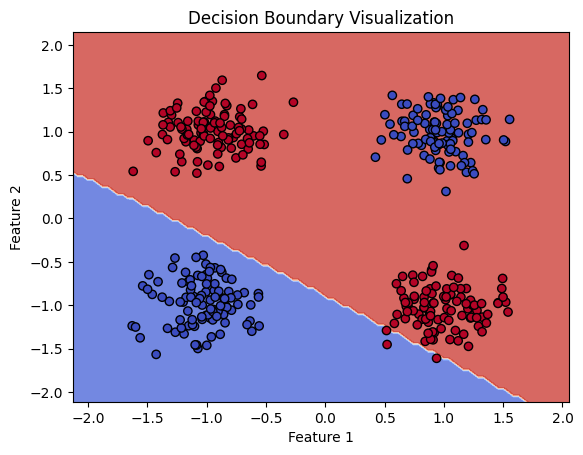

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Example of assigning model parameters
model = {
    'W1': np.random.rand(2, hidden_size),
    'W2': np.random.rand(hidden_size, 1),
    'b1': np.random.rand(hidden_size),    
    'b2': np.random.rand(1)               
}


# Generate a grid of points spanning the dataset range
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# Flatten the grid and prepare input
grid = np.c_[xx.ravel(), yy.ravel()]

# Compute predictions for the grid points
predictions = []
for pt in grid:
    z1 = np.dot(pt, model['W1']) + model['b1']
    h = np.tanh(z1)
    z2 = np.dot(h, model['W2']) + model['b2']
    predictions.append(1 if z2 > 0 else 0)

predictions = np.array(predictions).reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, predictions, alpha=0.8, cmap='coolwarm')
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap='coolwarm')
plt.title('Decision Boundary Visualization')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


### Reflection on the chart

The chart visualize the the decision boundary learned by the model which uses a simple forward pass, with fixed model prameters. It shows how well the model seperates the space into different classes such as 0 and 1.

Epoch 0, Loss: 1.0116
Epoch 100, Loss: 0.1475
Epoch 200, Loss: 0.0706
Epoch 300, Loss: 0.0456
Epoch 400, Loss: 0.0335
Epoch 500, Loss: 0.0264
Epoch 600, Loss: 0.0218
Epoch 700, Loss: 0.0185
Epoch 800, Loss: 0.0160
Epoch 900, Loss: 0.0141


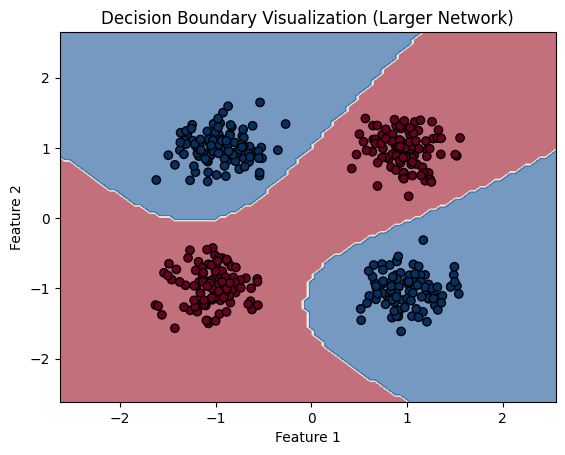

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Function to initialize a larger network
def initialize_model_large():
    input_dim = 2  
    hidden_dim = 10
    output_dim = 1 
    np.random.seed(42)
    
    # Random weight and bias initialization
    model = {
        "W1": np.random.randn(input_dim, hidden_dim),
        "b1": np.random.randn(hidden_dim),
        "W2": np.random.randn(hidden_dim, output_dim),
        "b2": np.random.randn(output_dim)
    }
    return model

# Function to compute forward pass
def forward_pass_large(X, model):
    z1 = np.dot(X, model['W1']) + model['b1']
    h = np.tanh(z1) 
    z2 = np.dot(h, model['W2']) + model['b2']
    y_pred = 1 / (1 + np.exp(-z2))  
    return y_pred, h

# Function for gradient descent with updated model
def train_model_large(X_train, y_train, model, learning_rate=0.1, epochs=1000):
    for epoch in range(epochs):
        y_pred, h = forward_pass_large(X_train, model)
        
        loss = -(y_train * np.log(y_pred) + (1 - y_train) * np.log(1 - y_pred)).mean()
   
        dz2 = y_pred - y_train
        dW2 = np.dot(h.T, dz2) / X_train.shape[0]
        db2 = np.sum(dz2, axis=0) / X_train.shape[0]
        
        dh = np.dot(dz2, model['W2'].T)
        dz1 = dh * (1 - h ** 2)  # Derivative of tanh
        dW1 = np.dot(X_train.T, dz1) / X_train.shape[0]
        db1 = np.sum(dz1, axis=0) / X_train.shape[0]
        
        model['W2'] -= learning_rate * dW2
        model['b2'] -= learning_rate * db2
        model['W1'] -= learning_rate * dW1
        model['b1'] -= learning_rate * db1

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.4f}")
    return model

# Function to plot decision boundary
def plot_decision_boundary_large(X, y, model):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    y_pred, _ = forward_pass_large(grid, model)
    y_pred = (y_pred > 0.5).astype(int)
    y_pred = y_pred.reshape(xx.shape)
    
    plt.contourf(xx, yy, y_pred, alpha=0.6, cmap=plt.cm.RdBu)
    plt.scatter(X[:, 0], X[:, 1], c=y.flatten(), edgecolor="k", cmap=plt.cm.RdBu)
    plt.title("Decision Boundary Visualization (Larger Network)")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

# Load your data
data = np.load('hw1_p2.npy', allow_pickle=True)
X, y = data[:, :2], data[:, 2:]
y = y.reshape(-1, 1)  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the larger model
model_large = initialize_model_large()
model_large = train_model_large(X_train, y_train, model_large)

# Plot the decision boundary for the larger network
plot_decision_boundary_large(X, y, model_large)


### Reflection on the chart



### Problem 3

In [50]:
import numpy as np

# Load the data files
data_file = "hw1_p3.npy"
ground_truth_file = "hw1_p3_gt.npy"

# Load data and ground truth
try:
    # Load the files
    data = np.load(data_file, allow_pickle=True)
    ground_truth = np.load(ground_truth_file, allow_pickle=True)

    # Check dimensionality
    print("Data and Ground Truth Overview")
    print("-" * 40)
    print(f"Data shape: {data.shape}")
    print(f"Ground truth shape: {ground_truth.shape}\n")

    # Display a preview of the data's structure (showing first 5 rows per dataset)
    print("Sample Data (Top 5 Rows):")
    print("-" * 40)
    for idx, row in enumerate(data[:5]):
        print(f"Dataset {idx + 1}:")
        print(row[:5], "\n")  # Show top 5 rows per dataset

    # Display a preview of the ground truth structure
    print("Sample Ground Truth (Top 5 Rows):")
    print("-" * 40)
    print(ground_truth[:, :5])  # Show the first 5 columns

except FileNotFoundError:
    print(f"Files not found. Please ensure {data_file} and {ground_truth_file} are in the same directory.")
except Exception as e:
    print(f"An error occurred: {e}")


Data and Ground Truth Overview
----------------------------------------
Data shape: (10, 50, 2)
Ground truth shape: (2, 1000)

Sample Data (Top 5 Rows):
----------------------------------------
Dataset 1:
[[-0.41915357  0.2051531 ]
 [-0.17143428  0.6831583 ]
 [-1.8750167  -0.14774029]
 [ 1.1502165   0.6290288 ]
 [-2.860527   -0.27653793]] 

Dataset 2:
[[-3.924172    1.3403729 ]
 [ 4.8286824   0.10795499]
 [-3.516522    0.9022625 ]
 [ 0.9563023   0.4143792 ]
 [-1.3660979   0.36516058]] 

Dataset 3:
[[-0.12512386  0.5227522 ]
 [ 2.935871   -0.61169744]
 [ 4.2585697   0.16233578]
 [ 1.1050922   0.67994654]
 [-2.969526   -0.06869838]] 

Dataset 4:
[[-4.6707726   0.1955268 ]
 [ 0.56111395  0.46886888]
 [-2.4171586  -0.5920125 ]
 [-0.31344414  0.26910198]
 [-1.1041015   0.1231865 ]] 

Dataset 5:
[[-4.970727    0.08242922]
 [ 2.7116203  -0.22015437]
 [ 1.070388    0.06496543]
 [ 3.0170112  -0.3768731 ]
 [-0.6709814   0.6042685 ]] 

Sample Ground Truth (Top 5 Rows):
---------------------------

### Reflection on the data dementionality

Data shape: (10, 50, 2) indicates there are 10 datasets, each containing 50 data points with 2 values per point (likely x and y).

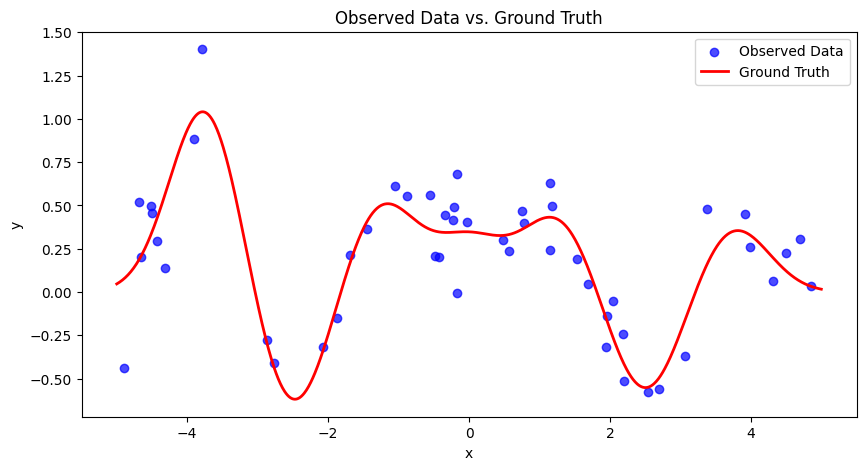

In [51]:
import matplotlib.pyplot as plt

# Parse x and y values from the dataset
dataset_index = 0  # Adjust to view other datasets if needed
x_values = data[dataset_index, :, 0]
y_values = data[dataset_index, :, 1]

# Ground truth values
ground_truth_x = ground_truth[0, :]
ground_truth_y = ground_truth[1, :]

# Visualize the first dataset
plt.figure(figsize=(10, 5))
plt.scatter(x_values, y_values, label="Observed Data", color="blue", alpha=0.7)
plt.plot(ground_truth_x, ground_truth_y, label="Ground Truth", color="red", linewidth=2)
plt.title("Observed Data vs. Ground Truth")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


### Reflection on the chart

The blue dots which are observed data points scatter around the red curve, highlighting the presence of noise. Inspite of the noise, the general trend of the observed data aligns well with the ground truth.

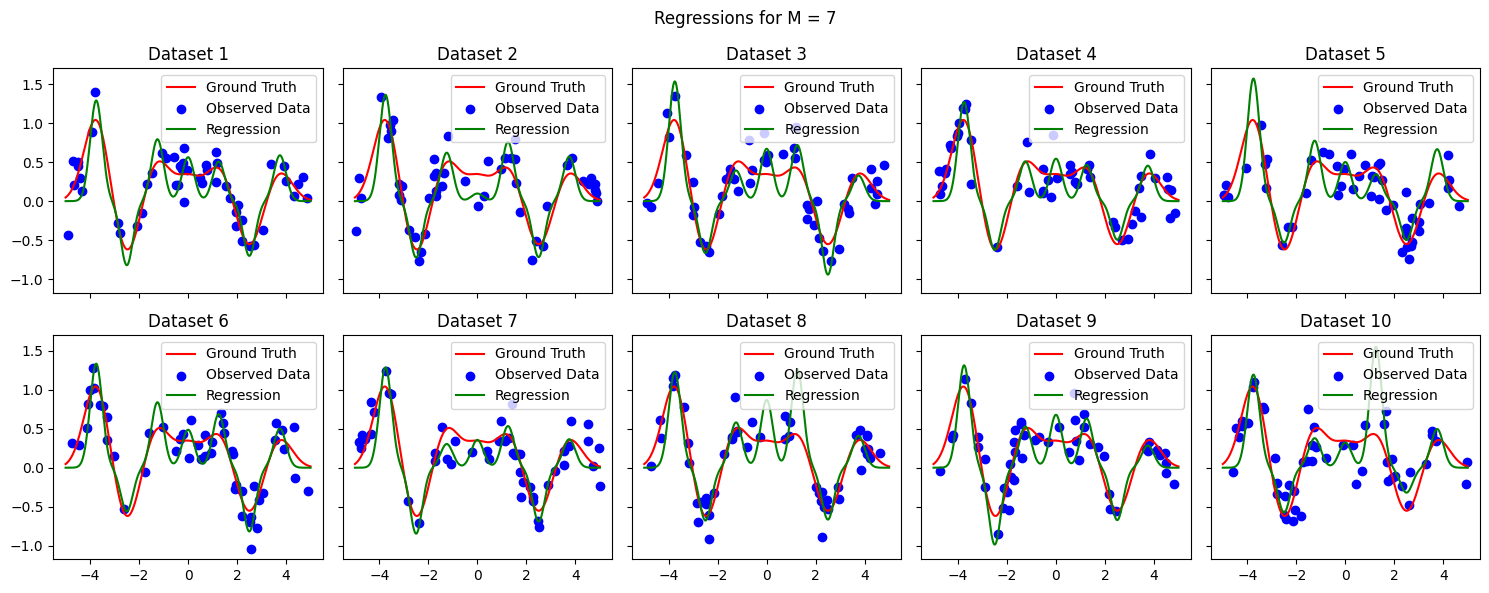

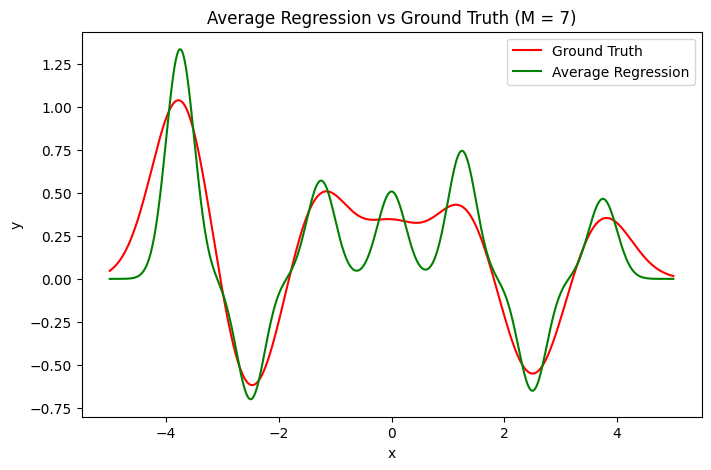

Bias 2: 0.029364593175899095
Variance: 0.012152520458277244
MSE: 0.04151711363417634


In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Load data and ground truth
data_file = "hw1_p3.npy"
ground_truth_file = "hw1_p3_gt.npy"

# Load files
data = np.load(data_file, allow_pickle=True)
ground_truth = np.load(ground_truth_file, allow_pickle=True)

# Extract x and y values from the data
num_datasets = data.shape[0]  # Number of datasets
x_values = [dataset[:, 0] for dataset in data]  # x-values from each dataset
y_values = [dataset[:, 1] for dataset in data]  # y-values from each dataset

# Ground truth values
x_gt = ground_truth[0]  # x-values (ground truth)
y_gt = ground_truth[1]  # y-values (ground truth)

# Define parameters
M = 7  # Number of basis functions
mu = np.linspace(-5, 5, M+2)[1:-1]  # Centers for Gaussian basis functions
s = 2 / (M + 1)  # Scaling parameter for Gaussians

# Define the Gaussian basis function
def phi(x, mu, s):
    return np.exp(-0.5 * ((x - mu) / s) ** 2)

# Build the design matrix for given x-values
def build_design_matrix(x, mu, s):
    return np.vstack([phi(x, m, s) for m in mu]).T

# Solve regression for each dataset
regressions = []  # Store regression outputs for all datasets

for i in range(num_datasets):
    x = x_values[i]
    y = y_values[i]

    # Build the design matrix
    Phi = build_design_matrix(x, mu, s)

    # Solve for weights using the normal equation
    w = np.linalg.pinv(Phi) @ y

    # Predict on ground truth x-values
    Phi_gt = build_design_matrix(x_gt, mu, s)
    y_pred = Phi_gt @ w
    regressions.append(y_pred)

# Calculate average regression f_bar
f_bar = np.mean(regressions, axis=0)

# Calculate bias, variance, and MSE
bias_squared = np.mean((f_bar - y_gt) ** 2)
variances = np.mean([np.mean((y_pred - f_bar) ** 2) for y_pred in regressions])
mse = bias_squared + variances

# Plot results
fig, axes = plt.subplots(2, 5, figsize=(15, 6), sharex=True, sharey=True)
axes = axes.ravel()

for i in range(num_datasets):
    axes[i].plot(x_gt, y_gt, label="Ground Truth", color="red")
    axes[i].scatter(x_values[i], y_values[i], label="Observed Data", color="blue")
    axes[i].plot(x_gt, regressions[i], label="Regression", color="green")
    axes[i].set_title(f"Dataset {i+1}")
    axes[i].legend()

fig.suptitle("Regressions for M = 7")
plt.tight_layout()
plt.show()

# Plot average regression vs ground truth
plt.figure(figsize=(8, 5))
plt.plot(x_gt, y_gt, label="Ground Truth", color="red")
plt.plot(x_gt, f_bar, label="Average Regression", color="green")
plt.title("Average Regression vs Ground Truth (M = 7)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

# Print bias, variance, and MSE
print(f"Bias 2: {bias_squared}")
print(f"Variance: {variances}")
print(f"MSE: {mse}")


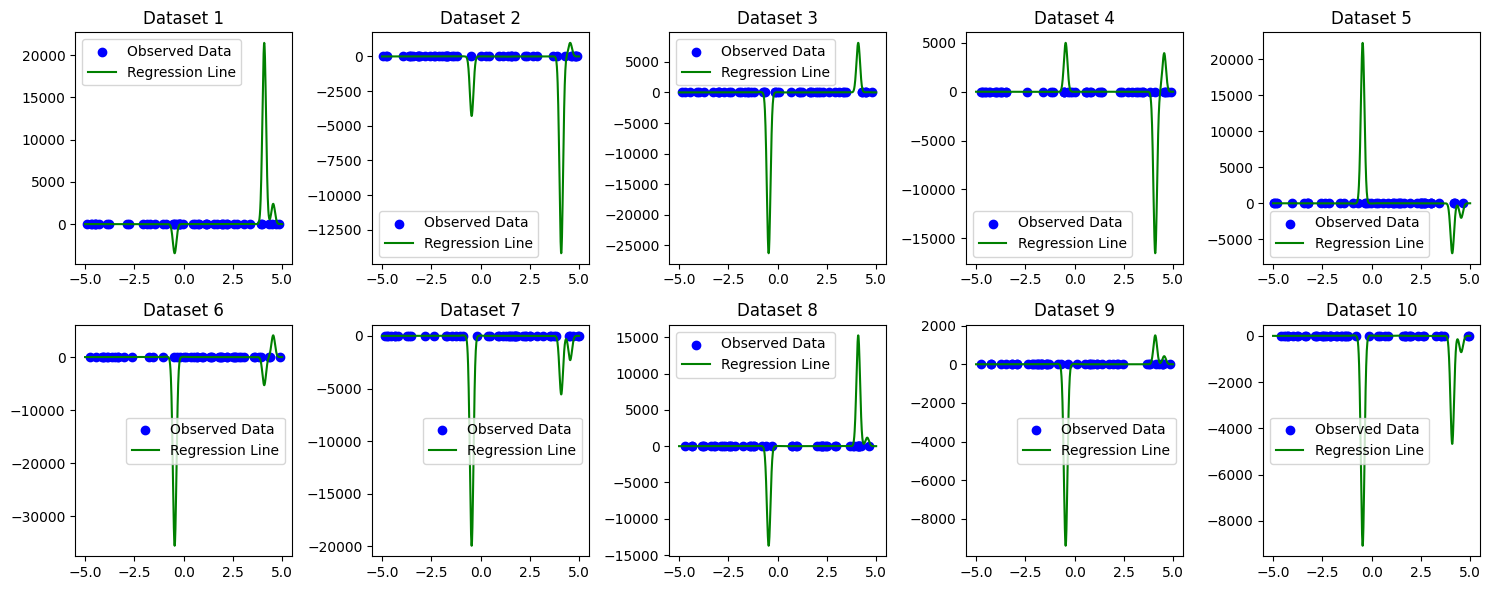

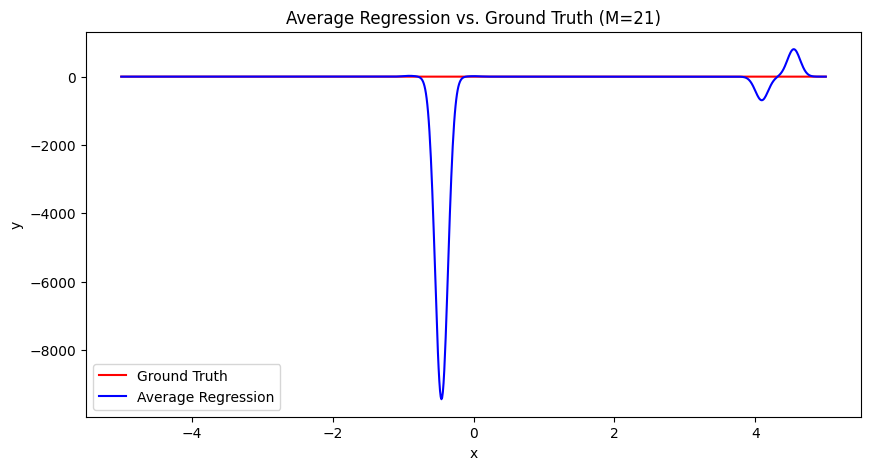

Bias for M=21: 839484762.1842883
Variance for M=21: 25245506717.30315
Mean squared error (MSE) for M=21: 26084991479.487434


In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Set parameters
M = 21  # Higher number of basis functions for overparameterization
mu = np.linspace(-5, 5, M+2)[1:-1]  # Equally spaced basis centers
s = 2 / (M + 1)  # Basis width

# Ground truth x-values
x_ground_truth = ground_truth[0]

# Compute design matrices and regression for each dataset
biases = []
variances = []
mse_list = []

predictions = []

for i in range(data.shape[0]):
    X = data[i, :, 0]
    y = data[i, :, 1]
    
    # Construct the design matrix Phi for training data
    Phi = np.exp(-0.5 * ((X[:, None] - mu[None, :]) / s) ** 2)
    
    # Solve the regression weights using closed-form solution
    w = np.linalg.inv(Phi.T @ Phi) @ Phi.T @ y
    
    # Predict on training input
    f_pred = Phi @ w
    predictions.append(f_pred)
    
    # Construct the design matrix for ground truth x-values
    Phi_gt = np.exp(-0.5 * ((x_ground_truth[:, None] - mu[None, :]) / s) ** 2)
    
    # Predict on ground truth input
    f_true_pred = Phi_gt @ w
    
    # Calculate bias and variance
    f_true = ground_truth[1]  # Actual ground truth
    bias = np.mean((np.mean(f_true_pred) - f_true) ** 2)
    variance = np.var(f_true_pred)
    biases.append(bias)
    variances.append(variance)
    mse = bias + variance
    mse_list.append(mse)

# Average regression over ground truth x-values
average_regression = np.mean([np.exp(-0.5 * ((x_ground_truth[:, None] - mu[None, :]) / s) ** 2) @ np.linalg.inv(Phi.T @ Phi) @ Phi.T @ y for X, y in zip(data[:, :, 0], data[:, :, 1])], axis=0)

# Visualization: Regressions on observed datasets
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()
for i in range(10):
    X = data[i, :, 0]
    y = data[i, :, 1]
    axes[i].scatter(X, y, color="blue", label="Observed Data")
    axes[i].plot(x_ground_truth, np.exp(-0.5 * ((x_ground_truth[:, None] - mu[None, :]) / s) ** 2) @ np.linalg.inv(Phi.T @ Phi) @ Phi.T @ y, color="green", label="Regression Line")
    axes[i].set_title(f"Dataset {i+1}")
    axes[i].legend()
    
plt.tight_layout()
plt.show()

# Plot average regression
plt.figure(figsize=(10, 5))
plt.plot(ground_truth[0], ground_truth[1], color="red", label="Ground Truth")
plt.plot(ground_truth[0], average_regression, color="blue", label="Average Regression")
plt.title("Average Regression vs. Ground Truth (M=21)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

# Report bias and variance
mean_bias = np.mean(biases)
mean_variance = np.mean(variances)
print(f"Bias for M=21: {mean_bias}")
print(f"Variance for M=21: {mean_variance}")
print(f"Mean squared error (MSE) for M=21: {np.mean(mse_list)}")


### Reflection on chart

The near-zero bias for M=21 suggests that the regression model is highly flexible and likely overfitting the data. The blue points appearing close to y=0 are likely caused by normalization issues or excessively large weight values (ww), which produce near-zero interpolated results in the design matrix. This poor generalization occurs because the large number of parameters (21) compared to just 10 data points makes the design matrix (ΦTΦ) ill-conditioned, leading to inaccuracies in computing the inverse during the weight calculation.

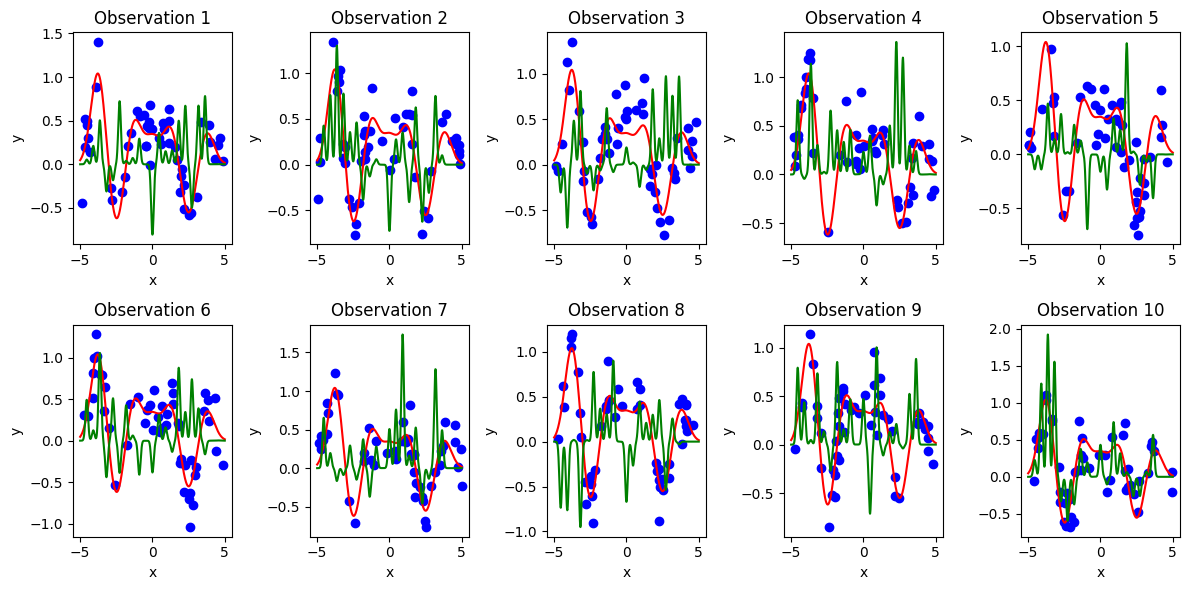

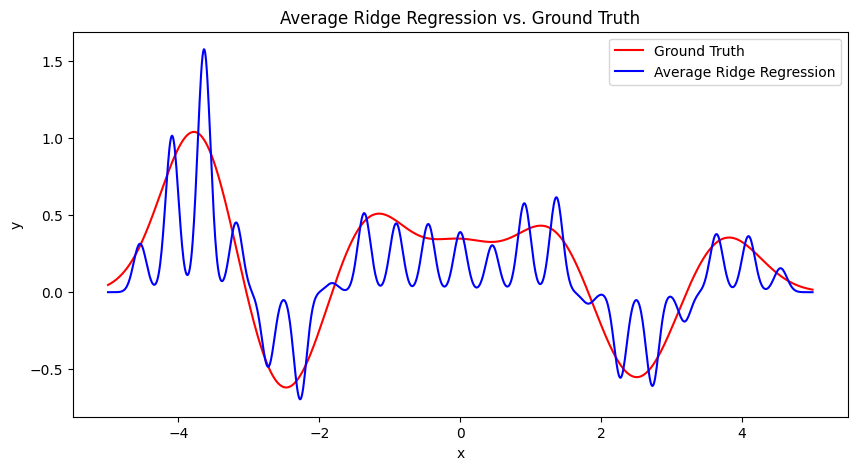

Bias 2 for Ridge Regression (M = 21, λ = 0.1): 0.06307252212763556
Variance for Ridge Regression (M = 21, λ = 0.1): 0.030472654654432444
Mean Squared Error (MSE): 0.093545176782068


In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Regularization parameter
lambda_reg = 0.1

# Recompute Phi matrix for M = 21
M = 21
mu = np.linspace(-5, 5, M + 2)[1:-1]
s = 2 / (M + 1)

# Ridge Regression weights computation
def ridge_regression(Phi, y, lambda_reg):
    identity_matrix = np.eye(Phi.shape[1])
    return np.linalg.inv(Phi.T @ Phi + lambda_reg * identity_matrix) @ Phi.T @ y

# Compute Phi matrix and perform regression for all 10 observations
predictions_ridge = []
for obs in data:
    x_obs = obs[:, 0]
    y_obs = obs[:, 1]
    Phi = np.exp(-(x_obs[:, None] - mu[None, :]) ** 2 / (2 * s ** 2))
    w_ridge = ridge_regression(Phi, y_obs, lambda_reg)
    predictions_ridge.append((Phi @ w_ridge).flatten())

# Generate plots for individual regressions
plt.figure(figsize=(12, 6))
x_obs_grid = ground_truth[0]
Phi_grid = np.exp(-(x_obs_grid[:, None] - mu[None, :]) ** 2 / (2 * s ** 2))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.scatter(data[i][:, 0], data[i][:, 1], color="blue", label="Data points")
    plt.plot(ground_truth[0], ground_truth[1], color="red", label="Ground Truth")
    plt.plot(ground_truth[0], Phi_grid @ ridge_regression(Phi, data[i][:, 1], lambda_reg), 
             color="green", label="Ridge Regression")
    plt.title(f"Observation {i+1}")
    plt.xlabel("x")
    plt.ylabel("y")
plt.tight_layout()
plt.show()

# Average regression
average_ridge_reg = np.mean(
    [Phi_grid @ ridge_regression(np.exp(-(obs[:, 0][:, None] - mu[None, :]) ** 2 / (2 * s ** 2)), 
                                obs[:, 1], lambda_reg)
     for obs in data], axis=0)

# Plot average regression vs. ground truth
plt.figure(figsize=(10, 5))
plt.plot(ground_truth[0], ground_truth[1], color="red", label="Ground Truth")
plt.plot(ground_truth[0], average_ridge_reg, color="blue", label="Average Ridge Regression")
plt.title("Average Ridge Regression vs. Ground Truth")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

# Bias and Variance calculations
bias_ridge = np.mean((average_ridge_reg - ground_truth[1]) ** 2)
variance_ridge = np.mean(
    np.var(
        [Phi_grid @ ridge_regression(np.exp(-(obs[:, 0][:, None] - mu[None, :]) ** 2 / (2 * s ** 2)), 
                                    obs[:, 1], lambda_reg)
         for obs in data], axis=0)
)
mse_ridge = bias_ridge + variance_ridge

print(f"Bias 2 for Ridge Regression (M = 21, λ = {lambda_reg}): {bias_ridge}")
print(f"Variance for Ridge Regression (M = 21, λ = {lambda_reg}): {variance_ridge}")
print(f"Mean Squared Error (MSE): {mse_ridge}")


### Reflection on the chart

Ridge Regression effectively reduces overfitting for M=21 by balancing bias and variance. The increased bias (0.063) compared to the unregularized case (∼0) reflects the penalty on large weights, which smooths the model but slightly reduces flexibility. Variance (0.030) is significantly lower, as Ridge Regression prevents overfitting to individual datasets. Overall, regularization (λ=0.1) enhances the model's balance between complexity and smoothness, mitigating overfitting and reducing errors while better capturing the underlying pattern.